# MDI341: TP Graphs

**Warning**: Ce notebook a été conçu pour fonctionner avec NetworkX version 1.11. De légers problèmes de compatibilité peuvent être rencontrés avec NetworkX 2.x.

In [1]:
import numpy as np
import random
import networkx as nx
from IPython.display import Image
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import metrics
import os.path
import urllib
import tarfile

In [2]:
print("Version de NetworkX: ", nx.__version__)

Version de NetworkX:  1.11


**Note** : la documentation de NetworkX se trouve [ici](http://networkx.readthedocs.io/)

## Analyse de graphes

### Erdős-Rényi

#### Question 1

On commence par créer et visualiser un graphe de type Erdős-Rényi avec n=200 noeuds et p=0.04. Vous aurez besoin des fonctions `nx.erdos_renyi_graph` et `nx.draw`.

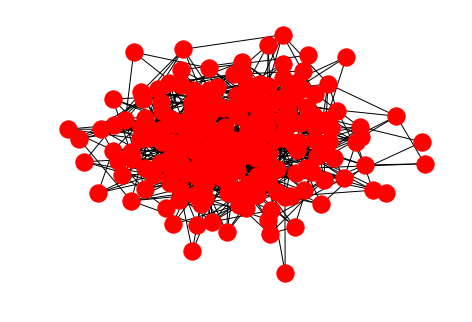

In [4]:
n = 200
p = 0.04
G_erdos = nx.erdos_renyi_graph(n, p)
nx.draw(G_erdos)

#### Question 2

Calculons des statistiques sur le nombre d'arêtes et la distribution des degrés.

In [5]:
degree_sequence_erdos = list(G_erdos.degree().values())
print("Le nombre d'arrête est {}".format(G_erdos.number_of_edges()))
print("Le nombre de noeuds est {}".format(G_erdos.number_of_nodes()))
print("Le degré moyen est {}, son espèrance étant de {}".format(np.mean(degree_sequence_erdos), n*p))
print("Le degré min est {}".format(np.min(degree_sequence_erdos)))
print("Le degré max est {}".format(np.max(degree_sequence_erdos)))
print("Le degré médian est {}".format(np.median(degree_sequence_erdos)))

Le nombre d'arrête est 807
Le nombre de noeuds est 200
Le degré moyen est 8.07, son espèrance étant de 8.0
Le degré min est 2
Le degré max est 15
Le degré médian est 8.0


#### Question 3

On trace la distribution des degrés en échelle normale, puis en échelle log-log. La fonction `nx.degree_histogram` vous sera utile.

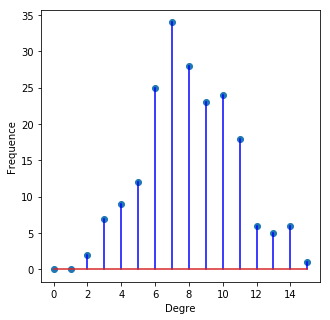

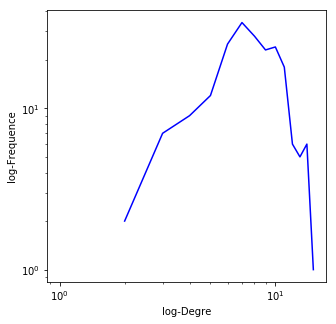

In [6]:
degree_freq = nx.degree_histogram(G_erdos)
y = degree_freq
plt.figure(figsize=(5, 5))
plt.stem(y, 'b-')
plt.ylabel("Frequence")
plt.xlabel("Degre")

plt.figure(figsize=(5, 5))
plt.loglog(y, 'b-')
plt.ylabel("log-Frequence")
plt.xlabel("log-Degre")

On retrouve bien une distribution binomiale.

#### Question 4

On calcule maintenant le coefficient de clustering global (voir `nx.clustering`)

In [7]:
cluster_coef = nx.average_clustering(G_erdos)

In [8]:
cluster_coef

0.040463369963369945

On retrouve a peu près la valeur de p prédite par la théorie (0.04)

#### Question 5

On affiche la longueur moyenne des plus courts chemins et le diamètre du graphe

In [86]:
try:
    print('La longueur moyenne des plus courts chemins est {:.2f}'.format(nx.average_shortest_path_length(G_erdos)))
    print('Le diamètre du graphe est {}'.format(nx.diameter(G_erdos)))
except:
    print('graph not connected')

La longueur moyenne des plus courts chemins est 2.80
Le diamètre du graphe est 5


En moyenne le chemin le plus court entre 2 noeuds est de 2.8 pour un graphe de 200 noeuds, on peut parler d'effet petit monde.

### Barabási–Albert

#### Question 6

On crée et visualise maintenant un graphe de Barabási–Albert avec n=200 noeuds (on ajoute à chaque fois m=3 arêtes), puis on applique la même analyse que celle faite pour Erdős-Rényi

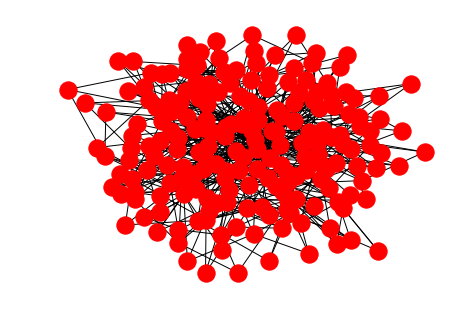

In [10]:
n = 200
m = 3
G_barabasi = nx.barabasi_albert_graph(n, m)
nx.draw(G_barabasi)

In [11]:
degree_sequence_barabasi = list(G_barabasi.degree().values())
print("Le nombre d'arrête est {}".format(G_barabasi.number_of_edges()))
print("Le nombre de noeuds est {}".format(G_barabasi.number_of_nodes()))
print("Le degré moyen est {}, son espèrance étant de {}".format(np.mean(degree_sequence_barabasi), n*p))
print("Le degré min est {}".format(np.min(degree_sequence_barabasi)))
print("Le degré max est {}".format(np.max(degree_sequence_barabasi)))
print("Le degré médian est {}".format(np.median(degree_sequence_barabasi)))

Le nombre d'arrête est 591
Le nombre de noeuds est 200
Le degré moyen est 5.91, son espèrance étant de 8.0
Le degré min est 3
Le degré max est 38
Le degré médian est 4.0


On trace la distribution des degrés en échelle normale, puis en échelle log-log. La fonction `nx.degree_histogram` vous sera utile.

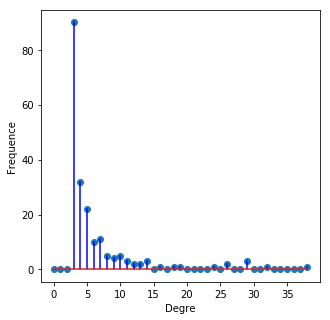

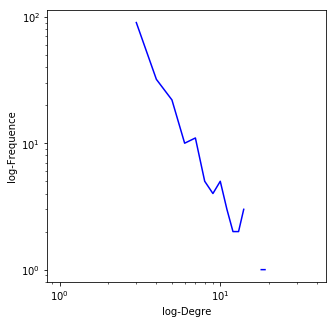

In [12]:
degree_freq_barabasi = nx.degree_histogram(G_barabasi)
y = degree_freq_barabasi
plt.figure(figsize=(5, 5))
plt.stem(y, 'b-')
plt.ylabel("Frequence")
plt.xlabel("Degre")

plt.figure(figsize=(5, 5))
plt.loglog(y, 'b-')
plt.ylabel("log-Frequence")
plt.xlabel("log-Degre")

On retrouve la distribution d'une loi de puissance.

On calcule maintenant le coefficient de clustering global (voir `nx.clustering`)

In [95]:
print(nx.average_clustering(G_barabasi))

0.12102430313558803


On affiche la longueur moyenne des plus courts chemins et le diamètre du graphe

In [91]:
try:
    print('La longueur moyenne des plus courts chemins est {:.2f}'.format(nx.average_shortest_path_length(G_barabasi)))
    print('Le diamètre du graphe est {}'.format(nx.diameter(G_barabasi)))
except:
    print('graph not connected')

La longueur moyenne des plus courts chemins est 2.84
Le diamètre du graphe est 5


## Graphe Karate Club

On va maintenant travailler sur un graphe réel de petite taille (n=34, m=78) qui représente les liens d'amitié entre les adhérents d'un club de karaté (le graphe est intégré à la librairie `networkx`)

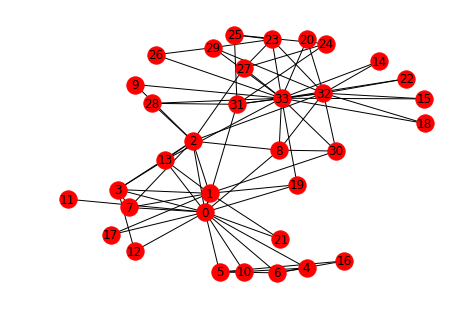

In [15]:
n=34
G_karate = nx.karate_club_graph()

# on définit une position des noeuds qui peut être ré-utilisée plusieurs fois
# en appelant la fonction nx.draw avec l'option pos=pos
pos = nx.spring_layout(G_karate)
nx.draw(G_karate, cmap = plt.get_cmap('rainbow'), with_labels=True, pos=pos)

#### Question 7

On va appliquer un clustering hiérarchique pour faire de la détection de communauté. On calcule d'abord la matrice des distances entre noeuds, où la distance entre 2 noeuds correspond à la longueur du plus court chemin

In [16]:
# le code suivant calcule une matrice de taille n x n
# distances[i, j] contient la longueur du plus court chemin entre les noeuds i et j
pcc_longueurs=nx.all_pairs_shortest_path_length(G_karate)
distances=np.zeros((n,n))

for i in range(n):
    for j in range(n):
        distances[i, j] = pcc_longueurs[i][j]

On peut maintenant utiliser l'implémentation de clustering hiérarchique ascendant de `scikit-learn` avec le *lien moyen* comme mesure de dissimilarité entre clusters. On affiche tout d'abord le clustering à 4 clusters

In [17]:
from sklearn.cluster import AgglomerativeClustering

agg_cl = AgglomerativeClustering(n_clusters=4,affinity='precomputed', linkage='average')
agg_cl.fit(distances)

AgglomerativeClustering(affinity='precomputed', compute_full_tree='auto',
            connectivity=None, linkage='average', memory=None,
            n_clusters=4, pooling_func='deprecated')

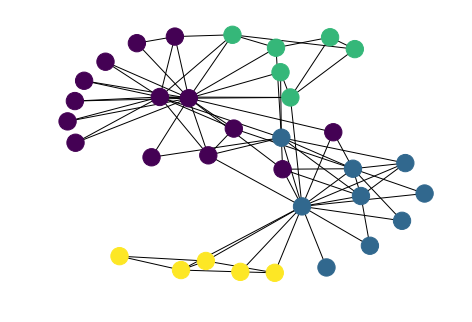

In [19]:
nx.draw(G_karate, node_color=agg_cl.labels_)

#### Question 8

On va mettre en évidence visuellement les différences entre quelques mesures de centralité des noeuds

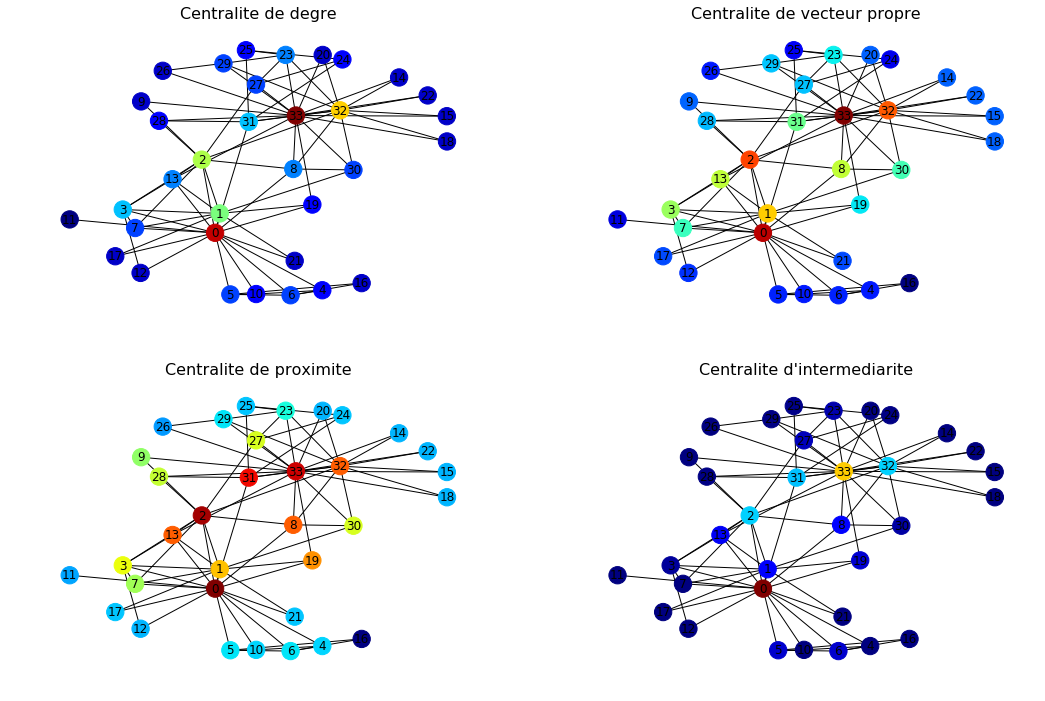

In [20]:
c_degree = list(nx.centrality.degree_centrality(G_karate).values())
c_eigenvector = list(nx.centrality.eigenvector_centrality(G_karate).values())
c_closeness = list(nx.centrality.closeness_centrality(G_karate).values())
c_betweenness = list(nx.centrality.betweenness_centrality(G_karate).values())

plt.figure(figsize=(18, 12))
f, axarr = plt.subplots(2, 2, num=1)
plt.sca(axarr[0,0])
nx.draw(G_karate, cmap = plt.get_cmap('jet'), node_color = c_degree, node_size=300, pos=pos, with_labels=True)
axarr[0,0].set_title('Centralite de degre', size=16)

plt.sca(axarr[0,1])
nx.draw(G_karate, cmap = plt.get_cmap('jet'), node_color = c_eigenvector, node_size=300, pos=pos, with_labels=True)
axarr[0,1].set_title('Centralite de vecteur propre', size=16)

plt.sca(axarr[1,0])
nx.draw(G_karate, cmap = plt.get_cmap('jet'), node_color = c_closeness, node_size=300, pos=pos, with_labels=True)
axarr[1,0].set_title('Centralite de proximite', size=16)

plt.sca(axarr[1,1])
nx.draw(G_karate, cmap = plt.get_cmap('jet'), node_color = c_betweenness, node_size=300, pos=pos, with_labels=True)
axarr[1,1].set_title('Centralite d\'intermediarite', size=16)

Dans la centralité de degré, les noeuds ayant le plus de connections sont les plus centraux.

Dans la centralité de vecteur propre, les noeuds connectés à des noeuds ayant de nombreuses connexions sont eux aussi considérés comme centraux.

La centralité de proximité révéle à quel point un noeud est proche des autres (au sens du plus court chemin).

Enfin la centralité d'intermediarité traduit le fait que certains noeuds soient des passages obligatoires pour accéder à d'autres noeuds.

### Graphe des produits Amazon

#### Question 9 (bonus +2 pts)

On va maintenant étudier un graphe de grande taille dont les noeuds sont des produits vendus par Amazon, et deux noeuds sont connectés si les deux produits sont fréquemment achetés ensemble (plus de détails [ici](https://snap.stanford.edu/data/com-Amazon.html))

In [22]:
# if os.path.exists('amazon.txt.gz') is False:
#     resp = urllib.urlretrieve('https://snap.stanford.edu/data/bigdata/' +
#                               'communities/com-amazon.ungraph.txt.gz', 'amazon.txt.gz')

G_amazon = nx.read_edgelist('amazon.txt.gz')

In [23]:
degree_sequence_amazon = list(G_amazon.degree().values())
print("Le nombre d'arrête est {}".format(G_amazon.number_of_edges()))
print("Le nombre de noeuds est {}".format(G_amazon.number_of_nodes()))
print("Le degré moyen est {}, son espèrance étant de {}".format(np.mean(degree_sequence_amazon), n*p))
print("Le degré min est {}".format(np.min(degree_sequence_amazon)))
print("Le degré max est {}".format(np.max(degree_sequence_amazon)))
print("Le degré médian est {}".format(np.median(degree_sequence_amazon)))

# degree_freq = nx.degree_histogram(G_amazon)
# y = degree_sequence_amazon
# plt.figure(figsize=(5, 5))
# plt.stem(y, 'b-')
# plt.ylabel("Frequence")
# plt.xlabel("Degre")

# plt.figure(figsize=(5, 5))
# plt.loglog(y, 'b-')
# plt.ylabel("log-Frequence")
# plt.xlabel("log-Degre")

# print(nx.average_clustering(G_amazon))

# try:
#     print('La longueur moyenne des plus courts chemins est {:.2f}'.format(nx.average_shortest_path_length(G_amazon)))
#     print('Le diamètre du graphe est {}'.format(nx.diameter(G_amazon)))
# except:
#     print('graph not connected')

Le nombre d'arrête est 925872
Le nombre de noeuds est 334863
Le degré moyen est 5.529855493141971, son espèrance étant de 1.36
Le degré min est 1
Le degré max est 549
Le degré médian est 4.0


Les calculs sont trop gourmands en ressource et font crasher le kernel.

## Prédiction dans les graphes

Un *ego-network* est un sous-graphe d'un réseau social centré sur un utilisateur. Ici on va travailler avec un ego-network Facebook (téléchargeable [ici](https://snap.stanford.edu/data/egonets-Facebook.html)) qui représente les amis d'un utilisateur donné (sans ce dernier) et les liens d'amitié entre eux. Le jeu de données contient 10 ego-networks, on va travailler avec l'un d'entre eux seulement qui se prête bien à la visualisation.

Nombre de noeuds: 150
Nombre d'arêtes: 1693
Nombre de composantes connexes: 2


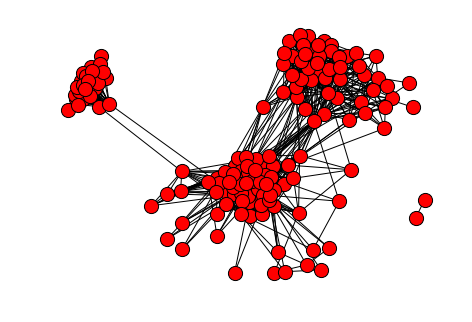

In [24]:
# if os.path.exists('facebook.tar.gz') is False:
#     resp = urllib.urlretrieve('https://snap.stanford.edu/data/facebook.tar.gz',
#                               'facebook.tar.gz')
tarfile.open("facebook.tar.gz", 'r:gz').extractall('.')

G_fb = nx.read_edgelist("facebook/414.edges")
n = G_fb.number_of_nodes()
m = G_fb.number_of_edges()
# on renumérote les noeuds de 0 à n-1
mapping=dict(zip(G_fb.nodes(), range(n)))
nx.relabel_nodes(G_fb, mapping, copy=False)
pos = nx.spring_layout(G_fb)
nx.draw(G_fb, node_size=200, pos=pos)
plt.gca().collections[0].set_edgecolor("#000000") # set node border color to black
print("Nombre de noeuds: %d" % n)
print("Nombre d'arêtes: %d" % m)
print("Nombre de composantes connexes: %d" % nx.number_connected_components(G_fb))

#### Question 10

On va maintenant essayer de prédire des liens dans le réseau. Pour cela, on commence par extraire une proportion des arêtes du graphe, dont on cherchera à prédire l'existence parmi toutes les arêtes non-existantes possibles. Le graphe d'apprentissage est le graphe original auquel on retire les arêtes sélectionnées.

In [25]:
# G_fb_train est une copie du graphe original
# auquel on a retiré 20% des arêtes choisies aléatoirement

proportion_edges = 0.2
edge_subset = random.sample(G_fb.edges(),
                            int(proportion_edges * G_fb.number_of_edges()))
G_fb_train = G_fb.copy()
G_fb_train.remove_edges_from(edge_subset)

edge_subset_size = len(list(edge_subset))
print("Nombre d'arêtes retirées: %d" % edge_subset_size)
print("Nombre d'arêtes restantes: %d" % (m - edge_subset_size))
print("Nombre total d'arêtes non-existantes: %d" %
      len(list(nx.non_edges(G_fb_train))))

Nombre d'arêtes retirées: 338
Nombre d'arêtes restantes: 1355
Nombre total d'arêtes non-existantes: 9820


On veut scorer les arêtes non-existantes de façon à ce que les arêtes réelles retirées aient un plus grand score. On utilise plusieurs mesures de similarité entre paires de noeud et on calcule l'Aire sous la Courbe ROC (AUC). On trace également les courbes ROC pour chaque similarité.

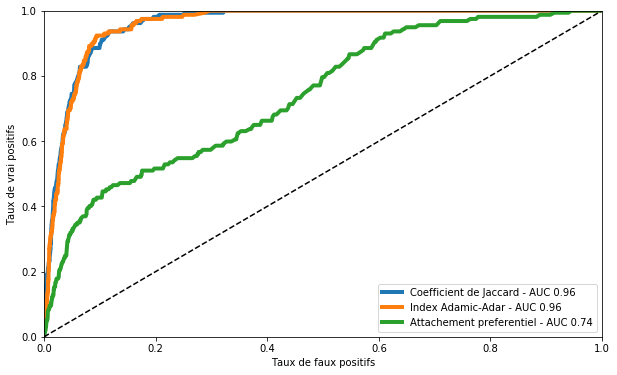

In [26]:
# exemple qui génère les scores et les labels (vrai arête ou fausse arête) avec jaccard
pred_jaccard = list(nx.jaccard_coefficient(G_fb_train))
score_jaccard, label_jaccard = zip(*[(s, (u,v) in edge_subset) for (u,v,s) in pred_jaccard])

fpr_jaccard, tpr_jaccard, thresholds = metrics.roc_curve(label_jaccard, score_jaccard)
auc_jaccard = metrics.roc_auc_score(label_jaccard,score_jaccard)

pred_adamic= list(nx.adamic_adar_index(G_fb_train))
score_adamic, label_adamic = zip(*[(s, (u,v) in edge_subset) for (u,v,s) in pred_adamic])

fpr_adamic, tpr_adamic, thresholds = metrics.roc_curve(label_adamic, score_adamic)
auc_adamic = metrics.roc_auc_score(label_adamic,score_adamic)

pred_pref = list(nx.preferential_attachment(G_fb_train))
score_pref, label_pref = zip(*[(s, (u,v) in edge_subset) for (u,v,s) in pred_pref])

fpr_pref, tpr_pref, thresholds = metrics.roc_curve(label_pref, score_pref)
auc_pref = metrics.roc_auc_score(label_pref,score_pref)
# afficher ROC curve et AUC
plt.figure(figsize=(10, 6))
plt.plot(fpr_jaccard, tpr_jaccard, label='Coefficient de Jaccard - AUC %.2f' % auc_jaccard, linewidth=4)
plt.plot(fpr_adamic, tpr_adamic, label='Index Adamic-Adar - AUC %.2f' % auc_adamic, linewidth=4)
plt.plot(fpr_pref, tpr_pref, label='Attachement preferentiel - AUC %.2f' % auc_pref, linewidth=4)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrai positifs')
plt.legend(loc='lower right')
plt.show()

Le coefficient de jaccard et l'index Adamic-Adar obtiennent les meilleurs résultats. Ce sont les plus à mêmes de prédire s'il manque une connection dans le graphe.

#### Question 11

On va maintenant faire de la classification semi-supervisée des noeuds. Pour cela on va utiliser les attributs qui sont fournis avec l'ego-network. Ces attributs représentent des caractéristiques (anonymisées) des utilisateurs du réseau. Dans la suite nous allons utiliser l'attribut `43` qui vaut `+1` (rouge) si la personne a étudié dans une école donnée, et `-1` (bleu) sinon.

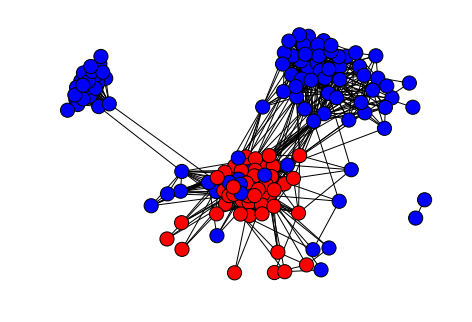

In [74]:
# on charge les labels des noeuds et on les affiche

with open('facebook/414.featnames') as f:
    for i, l in enumerate(f):
        pass

n_feat = i+1

features = np.zeros((n, n_feat))
f = open('facebook/414.feat', 'r')
for line in f:
    if line.split()[0] in mapping:
        node_id = mapping[line.split()[0]]
        features[node_id, :] = list(map(int, line.split()[1:]))

features = 2*features-1
feat_id = 43
labels = features[:, feat_id]

nx.draw(G_fb, cmap = plt.get_cmap('bwr'), nodelist=range(n), node_color = labels, node_size=200, pos=pos)
plt.gca().collections[0].set_edgecolor("#000000") # set node border color to black

On voit que cet attribut est relativement lisse sur le graphe, il se prête donc bien à la classification par propagation de label (ce n'est pas le cas de tous les attributs!). On va donc sélectionner aléatoirement une petite proportion de noeuds pour lesquels nous aurons accès aux labels. Notre tâche sera d'utiliser ces noeuds étiquetés ainsi que la structure du graphe pour prédire le label des autres noeuds. On regarde d'abord les noeuds étiquetés.

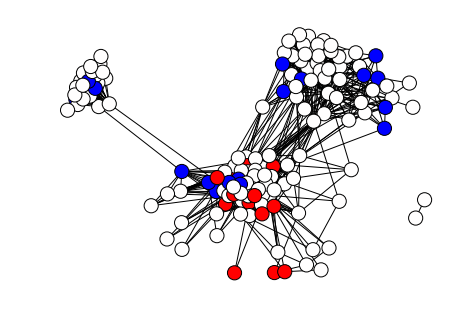

In [75]:
# on sélectionne 20% des noeuds pour lesquels on a accès à l'étiquette

random.seed(5)
proportion_nodes = 0.2
labeled_nodes = random.sample(G_fb.nodes(), int(proportion_nodes * G_fb.number_of_nodes()))

known_labels = np.zeros(n)
known_labels[labeled_nodes] = labels[labeled_nodes]

nx.draw(G_fb, cmap = plt.get_cmap('bwr'), nodelist=range(n), node_color = known_labels, node_size=200, pos=pos)
plt.gca().collections[0].set_edgecolor("#000000") # set node border color to black

On va maintenant appliquer la propagation de label et voir les résultats

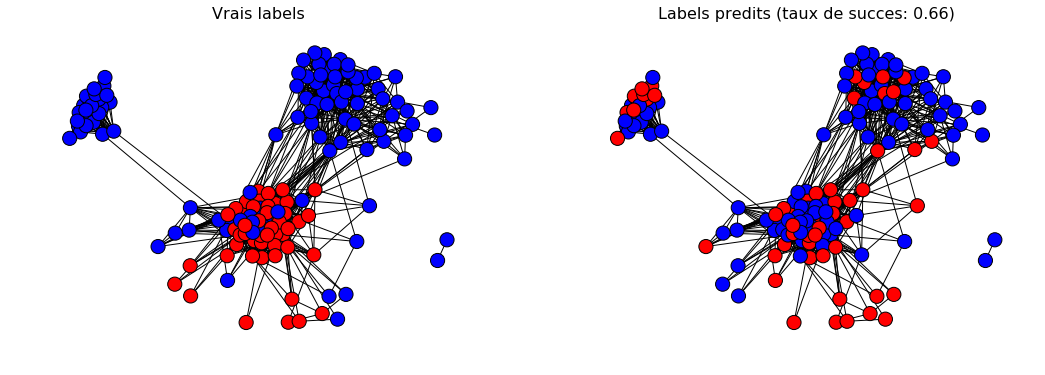

In [76]:
alpha = 0.7
L_sym = nx.normalized_laplacian_matrix(G_fb)

# on calcule la matrice de labels initiale
Y = np.zeros((n,2))
Y[known_labels==-1, 0] = 1
Y[known_labels==1, 1] = 1

# propagation de labels à faire ici

# labels prédits à mettre dans une variable F_pred pour affichage ci-dessous
F=np.linalg.inv((1-alpha)*np.identity(L_sym.shape[0])+L_sym)@Y
F_pred = np.argmax(F,axis=1).reshape(-1,1)
F_pred[F_pred==0]=-1
F_pred=np.array(F_pred.ravel())
# taux de succes a mettre dans une variable pred pour affichage ci-dessous
pred = (F_pred==labels.reshape(150)).mean()

plt.figure(figsize=(18, 6))
f, axarr = plt.subplots(1, 2, num=1)
plt.sca(axarr[0])
nx.draw(G_fb, cmap = plt.get_cmap('bwr'), nodelist=range(n), node_color = labels, node_size=200, pos=pos)
axarr[0].set_title('Vrais labels', size=16)
plt.gca().collections[0].set_edgecolor("#000000") # set node border color to black
plt.sca(axarr[1])
nx.draw(G_fb, cmap = plt.get_cmap('bwr'), nodelist=range(n), node_color = F_pred, node_size=200, pos=pos)
axarr[1].set_title('Labels predits (taux de succes: %.2f)' % pred, size=16)
plt.gca().collections[0].set_edgecolor("#000000") # set node border color to black